In [2]:
# Create a code to avoid all types of warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
warnings.filterwarnings(action="ignore",category=UserWarning)

In [3]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Efeito Adstock

O efeito adstock é uma técnica usada em Marketing Mix Modeling (MMM) para capturar o impacto prolongado de campanhas de marketing ao longo do tempo. Ele reflete a "memória" de uma campanha, ou seja, o efeito residual de um investimento em mídia em dias ou semanas após o gasto inicial. Esse conceito é crucial para medir corretamente o impacto de campanhas publicitárias, especialmente para canais como TV e rádio, onde o impacto pode não ser imediato.


Como Funciona o Adstock?
O adstock transforma uma série temporal de gastos em mídia, aplicando um decaimento aos efeitos passados. O decaimento é controlado por um parâmetro chamado taxa de decaimento ou taxa de retenção.

A Adstock é a composição de uma função de decaimento + lag.


A função de decaimento pode ser descrito por diversas funções, entre elas, uma simples a função geométrica, que há um decaimento exponencial no tempo. Nessa função, a taxa de decaimento é constante e pode variar entre canais de mídia, dependendo do quão rápido o consumidor esquece a ação.
$$ y_t = \sum_{i=0}^{L} x_{t} * \alpha^{i} $$
Onde $y_t$ é o investimento transformado no tempo, $x_t$ é o próprio investimento num determinado t, $\alpha$ é a taxa de decaimento e L é a duração máxima de retenção.


O Lag representa o tempo entre o investimento e o retorno, ou seja, é o atraso da resposta. Quanto maior o lag, mais disperso é o efeito. Também pode variar entre mídias. Ela é uma modificação da função de decaimento, em que se assume que há um delay entre a exposição à mídia e a resposta, ou seja.

A função geométrica com lag pode ser representada assim:
$$ y_t = \sum_{i=0}^{L} x_{t-1} * \alpha^{i-\theta} $$



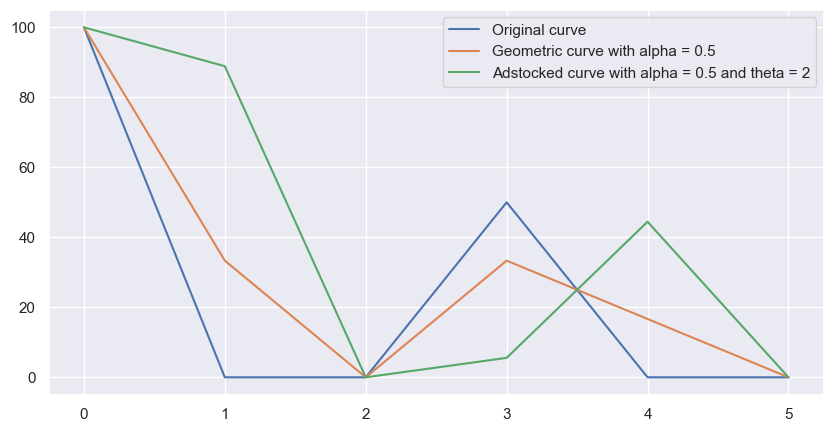

In [4]:
def geoDecay(alpha, L):
    '''
    weighted average with geometric decay
    weight_T = alpha ^ T-1 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**(np.ones(L).cumsum()-1)

def delayed_adstock(alpha, theta, L):
    '''
    weighted average with dealyed adstock function
    weight_T = alpha ^ (T-1 - theta)
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

def carryover(x, alpha, L, theta = None, func='geo'):
    '''
    1. x is a vector of media spend going back L timeslots, so it should be len(x) == L
    2. Weights is a vector of length L showing how much previous time periods spend has on current period. 
    3. L is max length of Lag.
    returns transformed vector of spend
    
    '''
    transformed_x = []
    if func=='geo':
        weights = geoDecay(alpha, L)
        
    elif func=='delayed':
        weights = delayed_adstock(alpha, theta, L)
    
    for t in range(x.shape[0]):
        upper_window = t+1
        lower_window = max(0,upper_window-L)
        current_window_x = x[:upper_window]
        t_in_window = len(current_window_x)
        if t < L:
            new_x = (current_window_x*np.flip(weights[:t_in_window], axis=0)).sum()
            transformed_x.append(new_x/weights[:t_in_window].sum())
        elif t >= L:
            current_window_x = x[upper_window-L:upper_window]
            ext_weights = np.flip(weights, axis=0) 
            new_x = (current_window_x*ext_weights).sum()
            transformed_x.append(new_x/ext_weights.sum())
            
    return np.array(transformed_x)

# plot the adstock and the original curve
a = pd.Series([100, 0, 0, 50, 0, 0])
L = 2
alpha = 0.5
theta = 2
plt.figure(figsize=(10, 5))
plt.plot(a, label="Original curve")
plt.plot(carryover(a, alpha, L, theta, func="geo"), label="Geometric curve with alpha = 0.5")
plt.plot(carryover(a, alpha, L, theta, func="delayed"), label="Adstocked curve with alpha = 0.5 and theta = 2")
plt.legend()
plt.show()

## Saturation Function
Investimentos em mídias não são lineares, pois se o investimento for muito baixo, pode não surtir efeito, enquanto que quando há um gasto excessivamente alto, pode ser que o retorno não seja igualmente alto; esse efeito é chamado saturação. 

Em MMM, é normal utilizar regressões lineares para capturar o efeito entre variáveis de marketing e a KPI de interesse, no entanto, como o efeito entre elas não é linear, é necessário realizar aplicar uma transformada que represente essa curva de saturação. 

_Obs: Se o modelo for de árvore, por exemplo, isso já é necessário, pois modelos de árvore deveriam capturar essa não linearidade._

Entre as funções mais indicadas para representar saturação, está a função de Hill, que é basicamente o estado da arte atual na literatura atual. Essa função pode ser descrita como:

$$ y = \frac{1}{1+(x_t/ \lambda)^{-\alpha}} $$

- $\alpha$ controla o formato da curva
- $\lambda$ controla o ponto de inflexão


Outras funções populares são a função exponencial, que tem dificuldade quando há um efeito de saturação muito rápido; e a função logarítmica, que tem dificuldade quando a saturação é muito rápida.

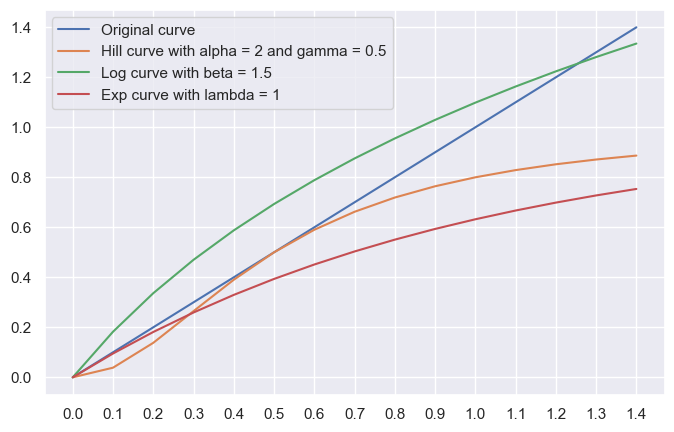

In [5]:
def hill_transform(x, alpha, gamma):
    return 1 / (1 + (x/gamma)**-alpha)

def logistic_saturation(x, beta):
    return np.log(1+beta * x)

def exponential_saturation(x, lambd):
    return 1 - np.exp(-lambd * x)

x = np.arange(0, 1.5, 0.1)
# plot the hill transformation and the original curve
plt.figure(figsize=(8, 5))
plt.plot(x, label="Original curve")
plt.plot(hill_transform(x, 2, 0.5), label="Hill curve with alpha = 2 and gamma = 0.5")
plt.plot(logistic_saturation(x, 2), label="Log curve with beta = 1.5")
plt.plot(exponential_saturation(x, 1), label="Exp curve with lambda = 1")
plt.legend()
# show correct labels in x ticks, that goes from np.arange(0, 1.5, 0.1)
plt.xticks(np.arange(0, len(np.arange(0, 1.5, 0.1)), 1), [round(i, 1) for i in np.arange(0, 1.5, 0.10)])
plt.show()

# Seasonality Function

The most basic way to achieve this is using dummy variables for seasons, months, weeks, days, etc. 
A more commonly used, and sophisticated method is using Fourier waves.
What this means is, seasonality is captured through a linear combination of sine and cosine waves at varying frequencies.
The number of (sine, cosine) pairs is called the degree of seasonality.

$$seasonality = \sum_{d}^{n} (\Beta_{d1} * \cos(\frac{2\pi d* t}{period}) + \Beta_{d2} * \sin(\frac{2\pi d* t}{period}))$$

Typically, n=2 captures most of the seasonalities in the sales without overfitting.


And period can be, for example, 4 weeks (montly seasonality), 52 weeks (yearly seasonality)

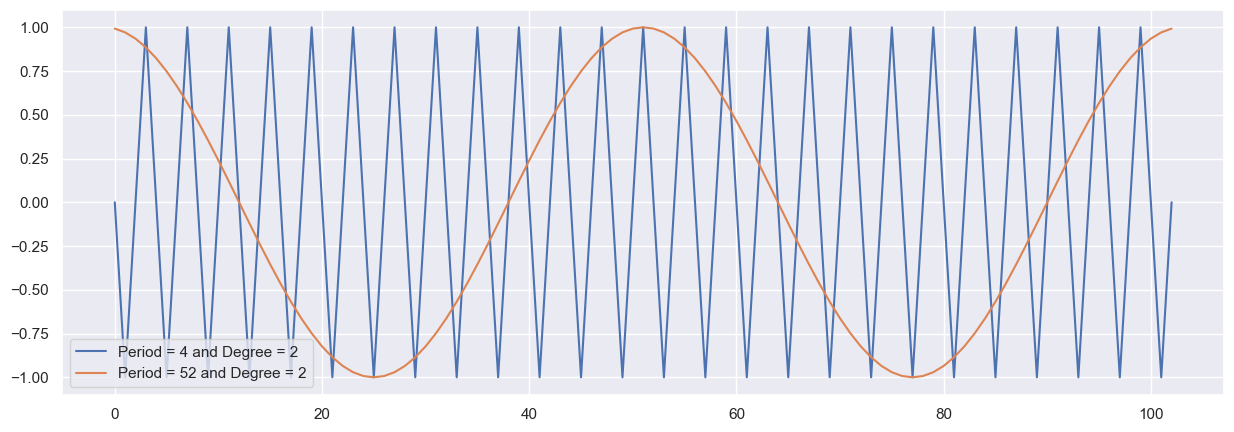

In [9]:
# write seasonality function

def seasonality(date_series, period=52, degree=2):
    df_seas = pd.DataFrame()
    for i in np.arange(1,degree+1):
        df_seas[f"cos_{i}"] = np.cos(2 * np.pi * i * date_series / period)
        df_seas[f"sin_{i}"] = np.sin(2 * np.pi * i * date_series / period)
    return df_seas

teste = pd.DataFrame({
    "t": np.arange(1, 52*2)
})

# plot the seasonality when period = 4 and degree = 2 and when period = 52 and degree = 2
plt.figure(figsize=(15, 5))
plt.plot(seasonality(teste["t"], period=4, degree=2).iloc[:, 0], label="Period = 4 and Degree = 2")
plt.plot(seasonality(teste["t"], period=52, degree=2).iloc[:, 0], label="Period = 52 and Degree = 2")
plt.legend()
plt.show()
